示例为利用pytorch中的RNN进行MNIST字体识别
即将图片的height视为timestep, width视为input

In [36]:
import os
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [37]:
# torch.manual_seed(1)

# 超参数
EPOCH = 1
BATCH_SIZE = 50
LR = 0.01   # 学习率
DOWNLOAD_MNIST = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # 选择CPU或GPU

In [38]:
# 下载训练数据
import torchvision
if not os.path.exists("./mnist/") or not os.listdir('./mnist/'):
    DOWNLOAD_MNIST = True
    
train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, 
                                       transform=torchvision.transforms.ToTensor(), download=DOWNLOAD_MNIST)

torch.Size([60000, 28, 28])
torch.Size([60000])


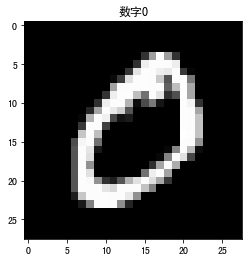

In [39]:
# plot
print(train_data.data.size())
print(train_data.targets.size())
plt.imshow(train_data.data[1].numpy(), cmap='gray')
plt.title("数字{}".format(train_data.targets[1].numpy()))
plt.show()

In [40]:
# dataloader
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
train_x_batch, train_y_batch=next(iter(train_loader))
print(train_x_batch.shape)
print(train_y_batch.shape)

torch.Size([50, 1, 28, 28])
torch.Size([50])


In [41]:
# 选取测试数据
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_data_n = test_data.data.float()/255.
test_label_n = test_data.targets
test_n = Data.TensorDataset(test_data_n, test_label_n)
test_loader = Data.DataLoader(dataset=test_n, batch_size=BATCH_SIZE, shuffle=True)
test_x_batch, test_y_batch=next(iter(test_loader))
print(test_x_batch.shape)
print(test_y_batch.shape)

torch.Size([50, 28, 28])
torch.Size([50])


In [42]:
# 构建LSTM网络
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = torch.nn.LSTM(num_layers=1, input_size=28, hidden_size=64, batch_first=True)
        self.fc = torch.nn.Linear(64, 10)
    def forward(self, x):
        # x shape:(batch, time_step, input_size)    where time_step=height, input=width
        # r_out shape:(batch, time_step, hidden_size)   
        # h_n shape:(n_layers, batch, hidden_size)
        # c_n shape:(n_layers, batch, hidden_size)
        r_out, (h_n, c_n) = self.lstm(x, None)
        output = self.fc(r_out[:,-1,:])     # 只取最后一个time_step的输出
        return output

net = Net().to(DEVICE)    # 移动到CPU或GPU
print(net)

Net(
  (lstm): LSTM(28, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)


In [43]:
# 定义优化器和损失函数
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [44]:
# 将训练的函数封装起来
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28, 28)    # 取消通道维度
        data, target = data.to(device), target.to(device)
        output = model(data)   
        loss = criteria(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [45]:
# 将测试的函数封装起来
def evaluate(model, device, test_loader):
    model.eval()    # 测试模式
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 28, 28)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criteria(output, target)
            pred = torch.max(output, dim=1)[1]
            correct += torch.sum(pred==target)
    correct = int(correct.numpy())
    avg_loss = test_loss/len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [46]:
for epoch in range(1, EPOCH+1):
    train(net, DEVICE, train_loader, optimizer, epoch)
    evaluate(net, DEVICE, test_loader)

Train Epoch: 1 [1450/60000 (2%)]	Loss: 1.464822
Train Epoch: 1 [2950/60000 (5%)]	Loss: 1.654003
Train Epoch: 1 [4450/60000 (7%)]	Loss: 1.120378
Train Epoch: 1 [5950/60000 (10%)]	Loss: 0.831667
Train Epoch: 1 [7450/60000 (12%)]	Loss: 0.639030
Train Epoch: 1 [8950/60000 (15%)]	Loss: 0.527314
Train Epoch: 1 [10450/60000 (17%)]	Loss: 0.476858
Train Epoch: 1 [11950/60000 (20%)]	Loss: 0.449790
Train Epoch: 1 [13450/60000 (22%)]	Loss: 0.272321
Train Epoch: 1 [14950/60000 (25%)]	Loss: 0.580731
Train Epoch: 1 [16450/60000 (27%)]	Loss: 0.178241
Train Epoch: 1 [17950/60000 (30%)]	Loss: 0.377349
Train Epoch: 1 [19450/60000 (32%)]	Loss: 0.286074
Train Epoch: 1 [20950/60000 (35%)]	Loss: 0.539971
Train Epoch: 1 [22450/60000 (37%)]	Loss: 0.524976
Train Epoch: 1 [23950/60000 (40%)]	Loss: 0.075221
Train Epoch: 1 [25450/60000 (42%)]	Loss: 0.212871
Train Epoch: 1 [26950/60000 (45%)]	Loss: 0.209061
Train Epoch: 1 [28450/60000 (47%)]	Loss: 0.060563
Train Epoch: 1 [29950/60000 (50%)]	Loss: 0.118728
Train Epo